# Finding the virial parameter from observables in Giant Molecular Clouds

## Background
Giant Molecular Clouds (GMCs) are the primary sites of star formation in galaxies. Star formation is expected to occur when the cloud can not resist its own self-gravity. This can be roughly described with the turbulent virial parameter $\alpha_\mathrm{turb}$, which is the ratio of the kinetic and gravitational energies. To calculate $\alpha_\mathrm{turb}$ one needs to have access to the full 3D distribution of cloud properties, but observations only provide positional data in 2D (just like our eyes), while velocities can only be measured along the line of sight. 

Here we train a regression model to estimate the physical value of $\alpha_\mathrm{turb}$ from observables. Since training requires us to know the true value of $\alpha$, we can't use observations, instead we will use data from one of the [FIRE simulations]( https://fire.northwestern.edu) that follows the formation of a galaxy that is similar to the Milky Way. 

![local image](m12i.png)

We identify clouds using a Friend-of-friends clustering algorithm on gas cells above a density $>10\,\mathrm{cm}^{-3}$. For details see [Benincasa+2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.497.3993B/abstract). For each cloud we calculate their properties (e.g., size, mass) using both the full 6D and the reduced observable data.

## The Data

After loading the data we calculate the base 10 logarithm for each cloud property. This is motivated by both physics, as we expect the virial parameter to be a product of these variables, and our need to compress the dynamic range of our data (astrophysical data often spans many orders of magnitudes).

In [1]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
sns.set()
%matplotlib inline

#Load dataframe
df = pd.read_csv('FIRE2_m12i_MHD_FoF_clouds.csv')
##Add log10 version of properties
for col_name in df.columns:
    if (not ('Log' in col_name) ):
        df['Log '+col_name] = np.log10(df[col_name])
observables = ['Log Mass', 'Log R_eff_obs', 'Log aspect_ratio_obs', 'Log f_n100', 'Log f_n1000', 'Log SFR', 'Log Z_mean',
               'Log B_mean_obs', 'Log T_mean', 'Log sigma_1D_obs', 'Log R_galactic']
df.dropna(inplace=True)
df.head()
#Get features
target_feature = 'alpha_turb'; log_target_feature = 'Log '+target_feature
X = df[observables]
y = df[log_target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=137, test_size=0.2)

C:\Users\gusze\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Most observers estimate turbulent virial parameter of a cloud with the following formula: $\alpha_\mathrm{turb} \approx 5 \sigma_\mathrm{1D}^2 R/(G M)$. This second part is derived by assuming the cloud to be homogeneous sphere with an isotropic velocity distribution. This is very far from reality, as clouds look more like [this](https://en.wikipedia.org/wiki/Taurus_molecular_cloud#/media/File:Herschel%E2%80%99s_view_of_the_Taurus_molecular_cloud_ESA384012.jpg). We adopt this approximation as our *null hypothesis* (NH) and try to improve on it.

In [2]:
def Null_Hypothesis(X, use_observed_only=True):
    df_red = df.loc[X.index]
    if use_observed_only:
        return df_red[log_target_feature+'_obs']
    else:
        if log_target_feature=='Log alpha_turb':
            return (2*df_red['Log sigma_1D']-1*df_red['Log Mass']+1*df_red['Log R_eff']-2.8579)
        else:
            print('No physical null hypothesis implemented for'+log_target_feature)

Let's check how well the null hypothesis is doing. First we use the expression of the NH, but plug in values calculated from the _full 6D data_. The result is a surprisingly good match between formula and the actual $\alpha_\mathrm{turb}$ value. This means that the spherical approximation works pretty well even if the clouds are fairly elongated.

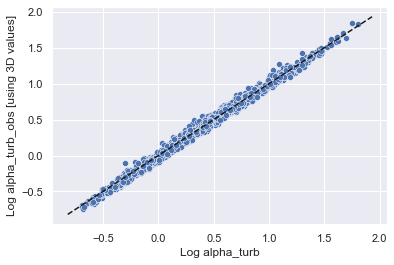

In [3]:
df[log_target_feature+'_obs [using 3D values]'] = Null_Hypothesis(X, use_observed_only=False)
sns.scatterplot(data=df,x=log_target_feature,y=log_target_feature+'_obs [using 3D values]')
plt.plot(plt.xlim(),plt.xlim(),'k--')
plt.show()

However if we use the observable versions of these properties the relationship becomes a lot less tight between the formula and the actual value, although they are still correlated. Note that this is a log-log plot, so the points that are 1 off are actually different by a factor of 10, so the scatter here is very significant.

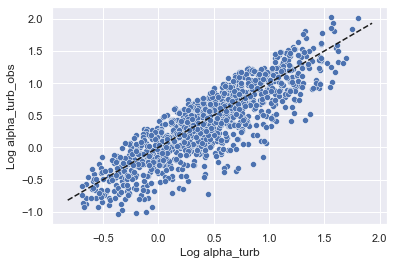

In [4]:
sns.scatterplot(data=df,x=log_target_feature,y=log_target_feature+'_obs')
plt.plot(plt.xlim(),plt.xlim(),'k--')
plt.show()

Since the formula is well correlated with the actual value, we are looking for a correction to the NH that reduces the scatter. Looking at the pairwise correlations, we find that most observables are fairly independent (counterexample: the larger a cloud is the more massive it is).

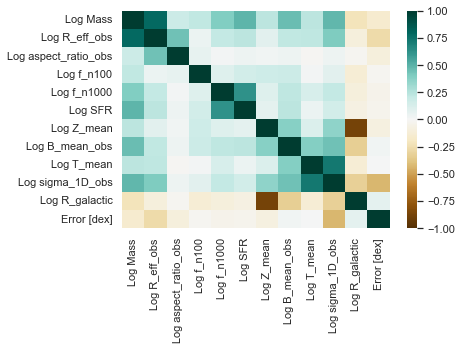

In [5]:
df['Error [dex]']=df[log_target_feature]-df[log_target_feature+'_obs']
sns.heatmap(pd.concat([X,df['Error [dex]']],axis=1).corr(),vmin=-1,vmax=1,cmap='BrBG');

The error shows the most correlation with the cloud size $R_\mathrm{eff}$ and velocity dispersion $\sigma_\mathrm{1D}$, and overall it seems that the formula is better at predicting $\alpha_\mathrm{turb}$ for large clouds (these also tend to have high $\sigma_\mathrm{1D}$).

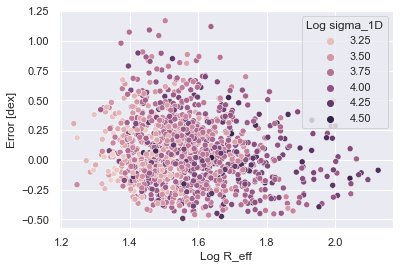

In [6]:
sns.scatterplot(data=df,x='Log R_eff',y='Error [dex]',hue='Log sigma_1D' );
#plt.legend([],[], frameon=False);

## Building a Regression Model
The next step is to train a regression model that performs better than the NH. We start out with simple regression models and move to progressively more complicated ones to see if they perform better.


To make things more concise later, we introduce a function here that can compare newly trained models with the NH.

In [7]:
#Import commonly used functions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [8]:
def compare_with_null_hypothesis(y_test,X_test,estimator,null_hypothesis_func, transform_functions=None):
    if 'predict' in dir(estimator):
        predict_func = estimator.predict
    else:
        predict_func = estimator
    if transform_functions is None:
        pred_vals = predict_func(X_test)
    else:
        X_rescaled = transform_functions['X_transform_func'].transform(X_test)
        pred_vals = transform_functions['y_transform_func'].inverse_transform(np.array(predict_func(X_rescaled)).reshape(-1, 1))
    null_vals = Null_Hypothesis(X_test)
    print('Comparing with Null-hypothesis:')
    rmse = np.sqrt(mean_squared_error(y_test, pred_vals))
    print('\tPrediction      1-RMSE/sigma_y: %g'%(1-rmse/y_test.std()))
    print('\tNull hypothesis 1-RMSE/sigma_y: %g'%(1-np.sqrt(mean_squared_error(y_test, Null_Hypothesis(X_test)))/y_test.std()))
    print('Examples:')
    print(tabulate({'Target':np.round(y_test,decimals=2)[:5],\
                    'Predicted':np.round(pred_vals,decimals=2)[:5],\
                    'Null-hypothesis':np.round(null_vals,decimals=2)[:5]}, headers='keys'))
    plt.scatter(y_test, null_vals)
    plt.plot(plt.xlim(),plt.xlim(),'k--')
    plt.xlabel(y_test.name)
    plt.ylabel('Null-hypothesis predictions')
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.show()
    plt.scatter(y_test,pred_vals)
    plt.plot(xlim,xlim,'k--')
    plt.xlabel(y_test.name)
    plt.ylabel('Predictions')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()


### Linear regression
It is useful to start out in any regression project with simple models and only move onto more complex ones if they fail to perform well. So we start out with linear regression with L2 regularization (i.e., Ridge-regression).

Training Score: 0.8422760761318302
Test Score: 0.8359263290824491
Column                  Exponent
--------------------  ----------
Log sigma_1D_obs            0.93
Log T_mean                  0.66
Log Mass                   -0.37
Log Z_mean                  0.22
Log aspect_ratio_obs        0.09
Log R_eff_obs               0.08
Log B_mean_obs              0.03
Log f_n100                 -0.02
Log R_galactic              0.01
Log SFR                    -0.01
Log f_n1000                -0
Comparing with Null-hypothesis:
	Prediction      1-RMSE/sigma_y: 0.595785
	Null hypothesis 1-RMSE/sigma_y: 0.452613
Examples:
  Target    Predicted    Null-hypothesis
--------  -----------  -----------------
    0.32         0.51               0.61
    0.41         0.29               0.16
    0.16         0.26              -0.07
    0.46         0.59               0.57
    0.42         0.44               0.49


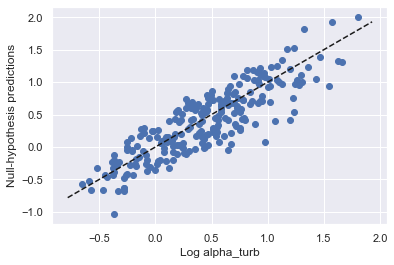

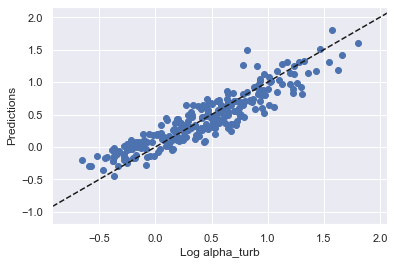

In [9]:
from sklearn.linear_model import Ridge
steps = [
    #('scalar', StandardScaler()),
    ('model', Ridge(alpha=1, fit_intercept=True))
]
ridge_pipe = Pipeline(steps)
ridge_pipe.fit(X_train, y_train)
print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test)))
sortind = np.argsort(-np.abs(ridge_pipe['model'].coef_))
#print("Prefactor: %g"%(10**ridge_pipe['model'].intercept_))
print(tabulate({'Column':X_test.columns[sortind],\
                'Exponent':np.round(ridge_pipe['model'].coef_,decimals=2)[sortind]},\
               headers='keys'))
compare_with_null_hypothesis(y_test,X_test,ridge_pipe, Null_Hypothesis)

Our main performance metric is  1 - (Root Mean Squred Error)/(Standard deviation of $\alpha_\mathrm{turb}$). This is significantly improved by the fit, the scatter is markedly lower (a factor of 2 vs 10).

We also find that many observables receive very small exponents, so we redo the fitting but with these "irrelevant" features removed. We get an equally good fit.

Training Score: 0.839497232714206
Test Score: 0.8321579706473619
Column                  Exponent
--------------------  ----------
Log sigma_1D_obs            0.94
Log T_mean                  0.66
Log Mass                   -0.45
Log Z_mean                  0.19
Log R_eff_obs               0.17
Log aspect_ratio_obs        0.07
Comparing with Null-hypothesis:
	Prediction      1-RMSE/sigma_y: 0.591169
	Null hypothesis 1-RMSE/sigma_y: 0.452613
Examples:
  Target    Predicted    Null-hypothesis
--------  -----------  -----------------
    0.32         0.48               0.61
    0.41         0.26               0.16
    0.16         0.25              -0.07
    0.46         0.57               0.57
    0.42         0.41               0.49


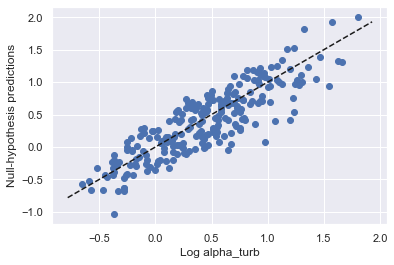

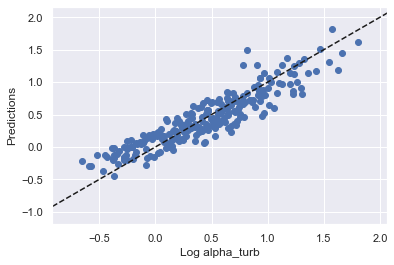

In [10]:
min_exponent = 0.05
relevant_columns = [col_name for i,col_name in enumerate(X.columns[sortind]) \
                    if np.abs(ridge_pipe['model'].coef_[sortind][i])>min_exponent]
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X[relevant_columns], y, random_state=137, test_size=0.2)
steps = [
    ('model', Ridge(alpha=1, fit_intercept=True))
]
ridge_pipe_2 = Pipeline(steps)
ridge_pipe_2.fit(X_train_2, y_train_2)
print('Training Score: {}'.format(ridge_pipe_2.score(X_train_2, y_train_2)))
print('Test Score: {}'.format(ridge_pipe_2.score(X_test_2, y_test_2)))
sortind2 = np.argsort(-np.abs(ridge_pipe_2['model'].coef_))
print(tabulate({'Column':X_test_2.columns[sortind2],\
                'Exponent':np.round(ridge_pipe_2['model'].coef_,decimals=2)[sortind2]},\
               headers='keys'))
compare_with_null_hypothesis(y_test_2,X_test_2,ridge_pipe_2, Null_Hypothesis)

### Polynomial regression
The scatterplot for the linear fit showed a slight "tilt" that can be a sign of a nonlinear relationship. So let us add higher order terms to our features and see if the fit improves. To further improve our fit we also look for the optimal value for the regularization parameter by doing a grid search.

Overall we find that this method does marginally better than the linear fit. Adding even higher order components does not improve the fit.

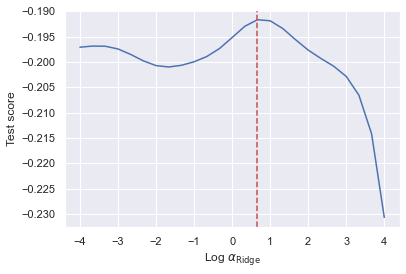

Best alpha value: 4.6
Training Score: 0.8657107299330712
Test Score: 0.8524511552375166
Comparing with Null-hypothesis:
	Prediction      1-RMSE/sigma_y: 0.61668
	Null hypothesis 1-RMSE/sigma_y: 0.452613
Examples:
  Target    Predicted    Null-hypothesis
--------  -----------  -----------------
    0.32         0.6                0.61
    0.41         0.31               0.16
    0.16         0.26              -0.07
    0.46         0.66               0.57
    0.42         0.41               0.49


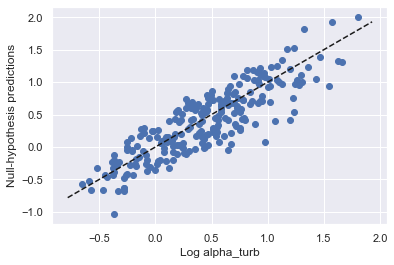

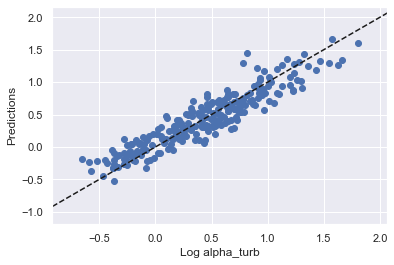

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
steps = [
    #('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2,include_bias=True)),
    ('model', Ridge(fit_intercept=True))
]
ridge_pipe = Pipeline(steps)
#Find optimal regularization parameter
alphavals = 10.0**np.linspace(-4,4,num=25) #values to try for the regularization parameter
parameters = {'model__alpha': alphavals}
clf = GridSearchCV(ridge_pipe, parameters,n_jobs=3,scoring='neg_root_mean_squared_error')
clf.fit(X_train, y_train)
#show how good the fits are for each regularization parameter
plt.plot(np.log10(alphavals),clf.cv_results_['mean_test_score']) 
plt.axvline(x=np.log10(clf.best_params_['model__alpha']),color='r', linestyle='--')
plt.xlabel(r'Log $\alpha_\mathrm{Ridge}$')
plt.ylabel('Test score')
plt.show()
#Let's choose the best one
estimator = clf.best_estimator_
print("Best alpha value: %3.2g"%(clf.best_params_['model__alpha']))
print('Training Score: {}'.format(estimator.score(X_train, y_train)))
print('Test Score: {}'.format(estimator.score(X_test, y_test)))
#print('Coefficients: ',np.round(estimator['model'].coef_,decimals=2))
#Compare with null-hypothesis
compare_with_null_hypothesis(y_test,X_test,estimator, Null_Hypothesis)

### Decision Tree Regression
Another simple, commonly used estimator. It has a tendency of overfitting we need to choose the optimal _max_depth_ value to avoid that.

Training Score: 0.9373640811128015
Test Score: 0.8105485491085997
Comparing with Null-hypothesis:
	Prediction      1-RMSE/sigma_y: 0.565648
	Null hypothesis 1-RMSE/sigma_y: 0.452613
Examples:
  Target    Predicted    Null-hypothesis
--------  -----------  -----------------
    0.32         0.54               0.61
    0.41         0.28               0.16
    0.16         0.24              -0.07
    0.46         0.51               0.57
    0.42         0.4                0.49


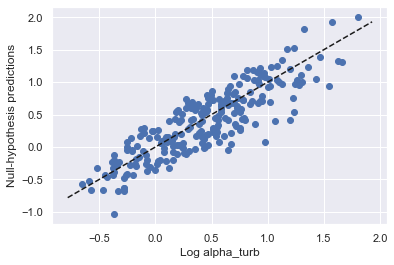

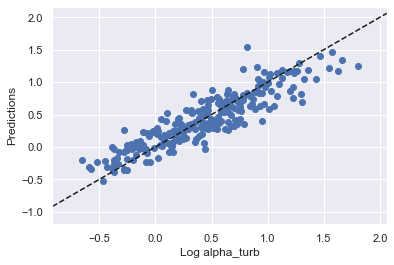

In [12]:
from sklearn.ensemble import RandomForestRegressor
steps = [
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100,max_depth=7,n_jobs=1) )
]
estimator = Pipeline(steps)
estimator.fit(X_train, y_train)
print('Training Score: {}'.format(estimator.score(X_train, y_train)))
print('Test Score: {}'.format(estimator.score(X_test, y_test)))
compare_with_null_hypothesis(y_test,X_test,estimator, Null_Hypothesis)

### K Nearest Neighbor Regression
This is essentially an interpolation in the feature space, can be fast and fairly accurate with dense data. The fit can be improved by tuning _n\_neighbors_ but in our case it always performs worse than linear regression, likely due to the relatively small number of clouds (~1200).

Training Score: 1.0
Test Score: 0.7776689620964276
Comparing with Null-hypothesis:
	Prediction      1-RMSE/sigma_y: 0.529463
	Null hypothesis 1-RMSE/sigma_y: 0.452613
Examples:
  Target    Predicted    Null-hypothesis
--------  -----------  -----------------
    0.32         0.45               0.61
    0.41         0.44               0.16
    0.16         0.12              -0.07
    0.46         0.53               0.57
    0.42         0.42               0.49


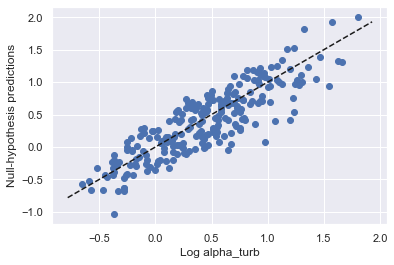

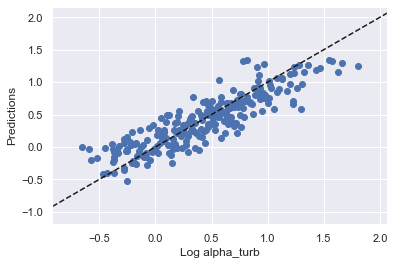

In [13]:
from sklearn.neighbors import KNeighborsRegressor
steps = [
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_neighbors=4,weights='distance') )
]
estimator = Pipeline(steps)
estimator.fit(X_train, y_train)
print('Training Score: {}'.format(estimator.score(X_train, y_train)))
print('Test Score: {}'.format(estimator.score(X_test, y_test)))
compare_with_null_hypothesis(y_test,X_test,estimator, Null_Hypothesis)


### Gradient Boosting Regression
A more advanced model that combines a decision tree with a gradient descent optimization. Here we use the heavily optimized _xgboost_ library. After experimenting with different training parameters, we find that gradient boosting can not outperform linear regression for this problem.

Training Score: 0.9553595548583723
Test Score: 0.832692354950657
Comparing with Null-hypothesis:
	Prediction      1-RMSE/sigma_y: 0.59182
	Null hypothesis 1-RMSE/sigma_y: 0.452613
Examples:
  Target    Predicted    Null-hypothesis
--------  -----------  -----------------
    0.32         0.54               0.61
    0.41         0.3                0.16
    0.16         0.14              -0.07
    0.46         0.64               0.57
    0.42         0.37               0.49


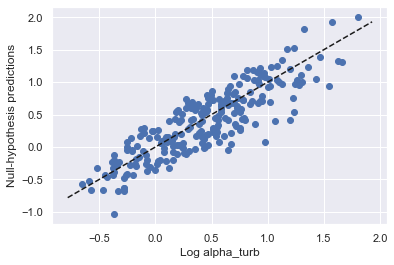

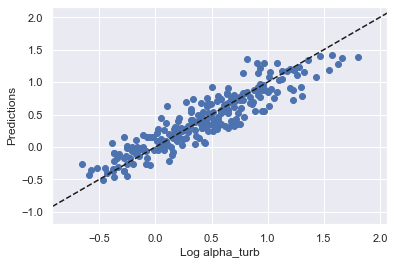

In [14]:
import xgboost as xgb
from xgboost import XGBRegressor
n_train_rounds = 100
xgb_X_train = xgb.DMatrix(X_train,label=y_train, missing=np.NaN);
xgb_X_test = xgb.DMatrix(X_test,label=y_test,missing=np.NaN); 
evallist = [(xgb_X_test, 'eval'), (xgb_X_train, 'train')]
xgb_param = {'max_depth': 5, 'learning_rate': 0.1, 'lambda': 10, 'objective': 'reg:squarederror'}
estimator = XGBRegressor(**xgb_param)
estimator.fit(X_train, y_train,eval_metric='rmse')


print('Training Score: {}'.format(estimator.score(X_train, y_train)))
print('Test Score: {}'.format(estimator.score(X_test, y_test)))
compare_with_null_hypothesis(y_test,X_test,estimator, Null_Hypothesis)

### Neural Network

The most sophisticated method we try is neural networks. Neural networks can approximate arbitrary nonlinear functions, so in theory they should applicable to any regression problem. They are also quite expensive to train and have a large number of free parameters (e.g., hidden layer structure), exploring which can be very time consuming. Here we use _Keras_ to build our model. We train until the score on the validation set converges

After some experimentation with the training parameters and the layer structure we find that neural networks offer a marginal improvement over linear regression for this dataset.

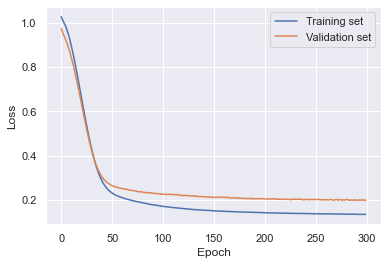

Comparing with Null-hypothesis:
	Prediction      1-RMSE/sigma_y: 0.601629
	Null hypothesis 1-RMSE/sigma_y: 0.452613
Examples:
  Target    Predicted    Null-hypothesis
--------  -----------  -----------------
    0.32         0.61               0.61
    0.41         0.32               0.16
    0.16         0.17              -0.07
    0.46         0.67               0.57
    0.42         0.42               0.49


C:\Users\gusze\anaconda3\lib\site-packages\tabulate\__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)


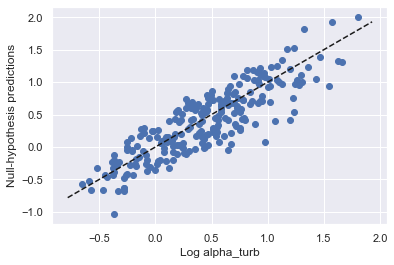

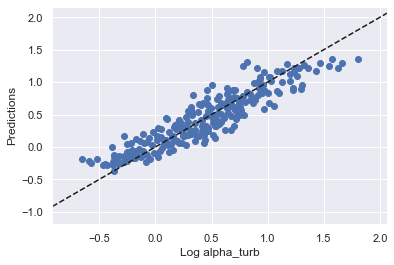

In [15]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

#This only works well if both input and output are normalized
scaler_x = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(np.array(y).reshape(-1, 1))
X_train_rescaled, X_test_rescaled = scaler_x.transform(X_train), scaler_x.transform(X_test)
y_train_rescaled = scaler_y.transform(np.array(y_train).reshape(-1, 1))
y_test_rescaled = scaler_y.transform(np.array(y_test).reshape(-1, 1))
#We will need these to tell the comparison function to rescale the inputs/outputs
transform_functions = {'X_transform_func':scaler_x, 'y_transform_func':scaler_y}

#Define neural network layers
model = Sequential()
model.add(Dense(4, kernel_initializer='normal', activation='softmax')) #first hidden layer
model.add(Dense(4, activation='softmax'))
model.add(Dense(1, activation='linear')) #Last layer, linear to get regressed value
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
#Do fitting
history = model.fit(X_train_rescaled, y_train_rescaled, epochs=300, batch_size=50,  verbose=0, validation_split=0.2,shuffle=True)
#model.summary()
#Plot loss vs epoch
plt.plot(history.history['loss'], label='Training set')
plt.plot(history.history['val_loss'], label='Validation set')
plt.ylabel('Loss');plt.xlabel('Epoch'); plt.legend()
plt.show()
#Evaluation on test set
#model.evaluate(X_test_rescaled,y_test_rescaled)
#Compare with null-hypothesis
compare_with_null_hypothesis(y_test,X_test,model, Null_Hypothesis,transform_functions=transform_functions)

## Summary

| Model | Score (1-RMSE/y_std) | 
| ---: | ---: |
| Null hypothesis | 0.453 |
| Linear Regression | 0.596 | 
| Linear Regression (fewer inputs) | 0.591 | 
| Polynomial Regression | 0.617 | 
| Decision Tree Regression| 0.572 |
| K-Nearest-Neighbor Regression| 0.529 |
| Gradient Boosting Regression| 0.592 |
| Neural Network Regression| 0.600 |

Overall we find that more sophisticated models offer marginal improvements over Linear Regression Linear Regression significantly improves over the null hypothesis ($\alpha_\mathrm{turb} \approx 5 \sigma_\mathrm{1D}^2 R/(G M)$), making the predictions accurate within a factor of 2 for almost all clouds (instead of 10). This model additionally requires the aspect ratio, as well as the average temperature ($T_\mathrm{mean}$)  and metallicity ($Z_\mathrm{mean}$) of the cloud.